In [ ]:
pip install tensorflow-quantum

     |████████████████████████████████| 10.5 MB 15.4 MB/s 
     |████████████████████████████████| 90 kB 5.0 MB/s 
     |████████████████████████████████| 1.6 MB 47.1 MB/s 
     |████████████████████████████████| 437 kB 10.9 MB/s 
     |████████████████████████████████| 6.1 MB 36.0 MB/s 
     |████████████████████████████████| 90 kB 9.8 MB/s 
     |████████████████████████████████| 100 kB 9.3 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.7 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████| 93 kB 1.4 MB/s 
     |████████████████████████████████| 92 kB 1.2 MB/s 
     |████████████████████████████████| 93 kB 1.5 MB/s 
     |████████████████████████████████

In [ ]:
! sudo apt-get install texlive-latex-recommended
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended


Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
!sudo apt install xelatex

Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package xelatex


In [ ]:
import numpy as np
import pandas as pd

#import tensorflow as tf
#from keras.layers import Input

import tensorflow as tf
import tensorflow.keras
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import backend as K

from scipy import signal
from scipy.fft import fftshift
import collections

import matplotlib
import matplotlib.pyplot as plt
import tensorflow_quantum as tfq
from matplotlib.pyplot import figure

import cirq
import sympy
import numpy as np
import seaborn as sns
from cirq.contrib.svg import SVGCircuit
from google.colab import files
import pickle
import seaborn as sn

matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})



In [ ]:
%tensorflow_version 2.x
#import tensorflow as tf
#print("Tensorflow version " + tf.__version__)
#try:
#  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
#except ValueError:
#  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')
#tf.config.experimental_connect_to_cluster(tpu)
#tf.tpu.experimental.initialize_tpu_system(tpu)
#tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [ ]:
from google.colab import drive

drive.mount('/gdrive', force_remount = True)

Xd = pd.read_pickle("/gdrive/MyDrive/RML2016.10a_dict.pkl")

Mounted at /gdrive


In [ ]:
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
print(snrs)
print(mods)

[-20, -18, -16, -14, -12, -10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
['8PSK', 'AM-DSB', 'AM-SSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


In [ ]:
# Load the dataset ...
#  You will need to seperately download or generate this file

#snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
mods = ["BPSK", "QPSK"]
snrs = [-2,0,2,4,10]
X = []
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

np.random.seed(2016)
n_examples = X.shape[0]
n_train = int(n_examples * 0.5)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), train_idx)))
Y_test = to_onehot(list(map(lambda x: mods.index(lbl[x][0]), test_idx)))

in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

print(X_train.transpose((0,2,1)).shape)

X_train = X_train.transpose((0,2,1))
X_test = X_test.transpose((0,2,1))
print(Y_train.shape)

(5000, 2, 128) [2, 128]
(5000, 128, 2)
(5000, 2)


In [ ]:
print(Y_train[2501])
print(Y_train[0])

[0. 1.]
[1. 0.]


In [ ]:
j = complex(0,1)

textwidth = 6.10356
#figure.set_size_inches(w=textwidth/2.5)
figure(figsize=(textwidth/2.1,3.8), dpi=200)

#figure.set_dpi(2000)
filenames = list()
Mod_Names = ["BPSK", "BPSK", "QPSK", "QPSK"]
k = 0
for i in [10,2400, 2560, 4980]:
  test_val = X_train[i]
  test_val = test_val[:,0] + j * test_val[:,1]
  f,t,Sxx = signal.spectrogram(test_val,nperseg=16, return_onesided = False)
  Sxx = 10 * np.log10(Sxx)
  image = plt.imshow(Sxx, origin="lower", cmap="gray")
  filename = Mod_Names[k] + "-Spectrogram-"+str(k%2) + ".pgf"
  plt.savefig(filename, bbox_inches = "tight")
  filenames.append(filename)
  k += 1

for f in filenames:
  files.download(f)
#print(test_val)


RuntimeError: ignored

In [ ]:
j = complex(0,1)

In [ ]:
def to_spectrogram(X):
  X_spectrogram = np.zeros( ( X.shape[0], 16, 9 ) )
  Complex_Train = X[:,:,0] + j * X[:,:,1]
  print(Complex_Train.shape)
  for i in range(Complex_Train.shape[0] ):
    f,t,Sxx = signal.spectrogram(Complex_Train[i],nperseg=16, return_onesided = False)
    X_spectrogram[i] = Sxx

  X_spectrogram = 10*np.log10(X_spectrogram)
  return X_spectrogram

In [ ]:
X_spectrogram_train = to_spectrogram(X_train)
X_spectrogram_test = to_spectrogram(X_test)
print(X_spectrogram_train.shape)



(5000, 128)
(5000, 128)
(5000, 16, 9)


In [ ]:
def downscale(X):
  small = tf.concat(X, axis = 0)
  small = small[... , tf.newaxis ]
  return tf.image.resize(small, (4,4)).numpy()

In [ ]:
# Downscale the images
X_spec_small_train = downscale(X_spectrogram_train)
X_spec_small_test = downscale(X_spectrogram_test)
print(X_spec_small_train.shape)

(5000, 4, 4, 1)


In [ ]:
# Remove Duplicates
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)


In [ ]:
print(Y_train[:,0])

[1. 0. 1. ... 1. 1. 1.]


In [ ]:
X_train_nocon, Y_train_nocon = remove_contradicting(X_spec_small_train, Y_train[:,0])

Number of unique images: 5000
Number of unique 3s:  2472
Number of unique 6s:  2528
Number of unique contradicting labels (both 3 and 6):  0

Initial number of images:  5000
Remaining non-contradicting unique images:  5000


In [ ]:
# convert To binary encoding
THRESHOLD = -50

x_train_bin = np.array(X_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(X_spec_small_test > THRESHOLD, dtype=np.float32)


In [ ]:
_ = remove_contradicting(x_train_bin, Y_train[:,0])

Number of unique images: 1701
Number of unique 3s:  730
Number of unique 6s:  633
Number of unique contradicting labels (both 3 and 6):  338

Initial number of images:  5000
Remaining non-contradicting unique images:  1363


In [ ]:
def convert_to_circuit(image):
  """Encode truncated classical image into quantum datapoint."""
  values = np.ndarray.flatten(image)
  qubits = cirq.GridQubit.rect(4, 4)
  circuit = cirq.Circuit()
  for i, value in enumerate(values):
      if value:
          circuit.append(cirq.X(qubits[i]))
  return circuit


x_train_circ = [convert_to_circuit(x) for x in x_train_bin]
x_test_circ = [convert_to_circuit(x) for x in x_test_bin]

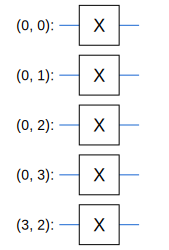

In [ ]:
SVGCircuit(x_train_circ[4])

In [ ]:
x_train_tfcirc = tfq.convert_to_tensor(x_train_circ)
x_test_tfcirc = tfq.convert_to_tensor(x_test_circ)

In [ ]:
class CircuitLayerBuilder():
    def __init__(self, data_qubits, readout):
        self.data_qubits = data_qubits
        self.readout = readout

    def add_layer(self, circuit, gate, prefix):
        for i, qubit in enumerate(self.data_qubits):
            symbol = sympy.Symbol(prefix + '-' + str(i))
            circuit.append(gate(qubit, self.readout)**symbol)

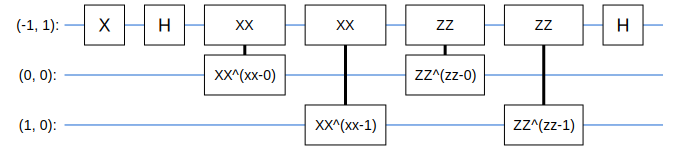

In [ ]:
rdout = cirq.GridQubit(-1,1)
demo_builder = CircuitLayerBuilder(data_qubits = cirq.GridQubit.rect(2,1),
                                   readout=rdout )

circuit = cirq.Circuit()
circuit.append(cirq.X(rdout))
circuit.append(cirq.H(rdout))
demo_builder.add_layer(circuit, gate = cirq.XX, prefix='xx')
demo_builder.add_layer(circuit, gate = cirq.ZZ, prefix='zz')
circuit.append(cirq.H(rdout))
SVGCircuit(circuit)

In [ ]:
def create_quantum_model():
    """Create a QNN model circuit and readout operation to go along with it."""
    data_qubits = cirq.GridQubit.rect(4, 4)  # a 4x4 grid.
    readout = cirq.GridQubit(-1, -1)         # a single qubit at [-1,-1]
    circuit = cirq.Circuit()

    # Prepare the readout qubit.
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))

    builder = CircuitLayerBuilder(
        data_qubits = data_qubits,
        readout=readout)

    # Then add layers (experiment by adding more).
    builder.add_layer(circuit, cirq.XX, "xx1")
    builder.add_layer(circuit, cirq.ZZ, "zz1")

    # Finally, prepare the readout qubit.
    circuit.append(cirq.H(readout))

    return circuit, cirq.Z(readout)

In [ ]:
model_circuit, model_readout = create_quantum_model()

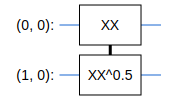

In [ ]:
q = cirq.GridQubit(0, 0)
v = cirq.GridQubit(1,0)

(a, b, c) = sympy.symbols("a b c")
circuit = cirq.Circuit(
    cirq.XX(q,v)**0.5
)


SVGCircuit(circuit)

In [ ]:
cirq.unitary( cirq.XX(q,v) ** 0.5 )

array([[0.5+0.5j, 0. +0.j , 0. +0.j , 0.5-0.5j],
       [0. +0.j , 0.5+0.5j, 0.5-0.5j, 0. +0.j ],
       [0. +0.j , 0.5-0.5j, 0.5+0.5j, 0. +0.j ],
       [0.5-0.5j, 0. +0.j , 0. +0.j , 0.5+0.5j]])

In [ ]:
from cirq import Simulator
simulator = Simulator()
result = simulator.simulate(circuit, qubit_order=[q, v])
print(np.around(result.final_state_vector, 3))


[0.5+0.5j 0. +0.j  0. +0.j  0.5-0.5j]


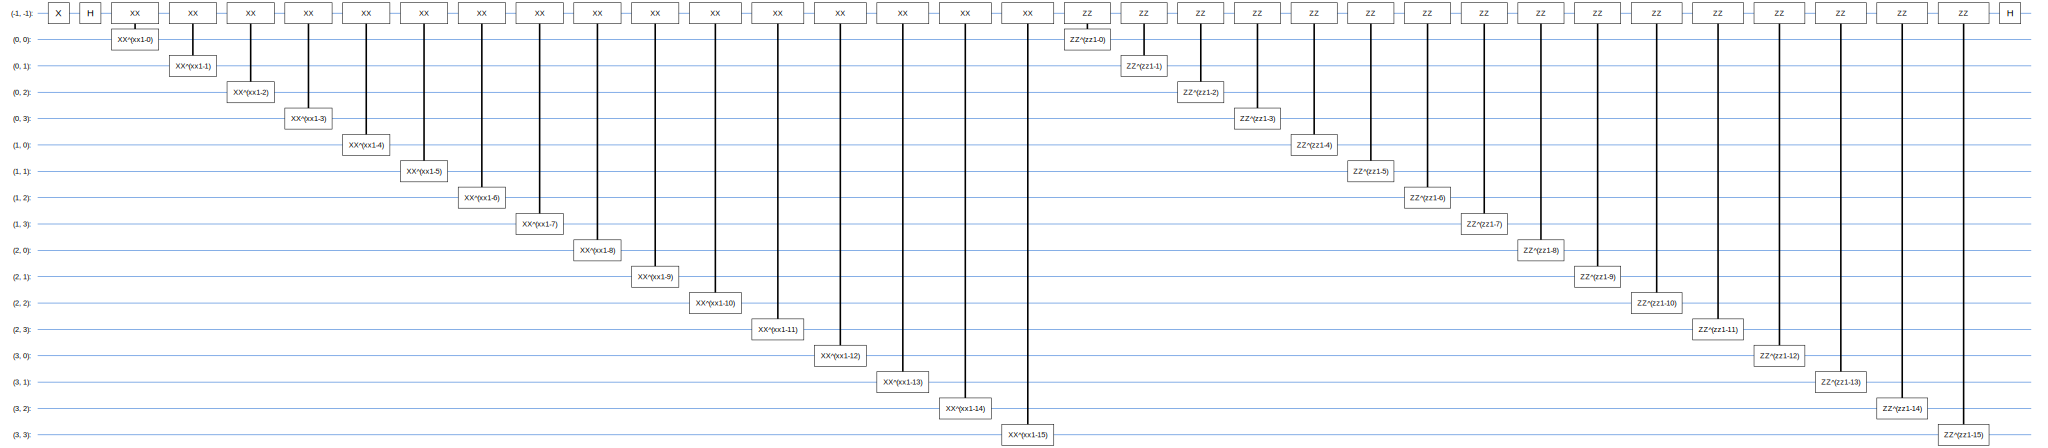

In [ ]:
SVGCircuit(model_circuit)

In [ ]:
model = tf.keras.Sequential([
    # The input is the data-circuit, encoded as a tf.string
    tf.keras.layers.Input(shape=(), dtype=tf.string),
    # The PQC layer returns the expected value of the readout gate, range [-1,1].
    tfq.layers.PQC(model_circuit, model_readout),
])

In [ ]:
y_train_hinge = 2.0*Y_train_nocon-1.0
y_test_hinge = 2.0*Y_test[:,0]-1.0

In [ ]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [ ]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 pqc (PQC)                   (None, 1)                 32        
                                                                 
Total params: 32
Trainable params: 32
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
EPOCHS = 5
BATCH_SIZE = 32
filepath = 'QNN.wts.h5'
NUM_EXAMPLES = len(x_train_tfcirc)
#NUM_EXAMPLES = 500
x_train_tfcirc_sub = x_train_tfcirc[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [ ]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_tfcirc, y_test_hinge),
    )

qnn_results = model.evaluate(x_test_tfcirc, Y_test)

Epoch 1/5
157/157 [==============================] - 622s 4s/step - loss: 0.9044 - hinge_accuracy: 0.5611 - val_loss: 0.9145 - val_hinge_accuracy: 0.5500
Epoch 2/5
157/157 [==============================] - 616s 4s/step - loss: 0.8958 - hinge_accuracy: 0.5673 - val_loss: 0.9087 - val_hinge_accuracy: 0.5494
Epoch 3/5
157/157 [==============================] - 624s 4s/step - loss: 0.8888 - hinge_accuracy: 0.5687 - val_loss: 0.9047 - val_hinge_accuracy: 0.5543
Epoch 4/5
157/157 [==============================] - 620s 4s/step - loss: 0.8820 - hinge_accuracy: 0.5713 - val_loss: 0.9010 - val_hinge_accuracy: 0.5579
Epoch 5/5
157/157 [==============================] - 96s 610ms/step - loss: 1.0000 - hinge_accuracy: 0.0000e+00


In [ ]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
matplotlib.rcParams['text.latex.unicode']=True

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
  import sys


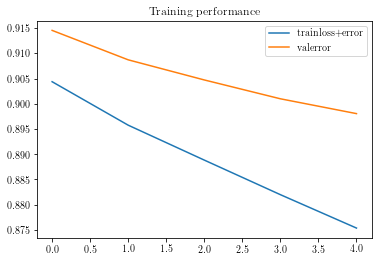

In [ ]:
plt.title('Training performance')
plt.plot(qnn_history.epoch, qnn_history.history['loss'], label='trainloss+error')
plt.plot(qnn_history.epoch, qnn_history.history['val_loss'], label='valerror')
plt.legend()

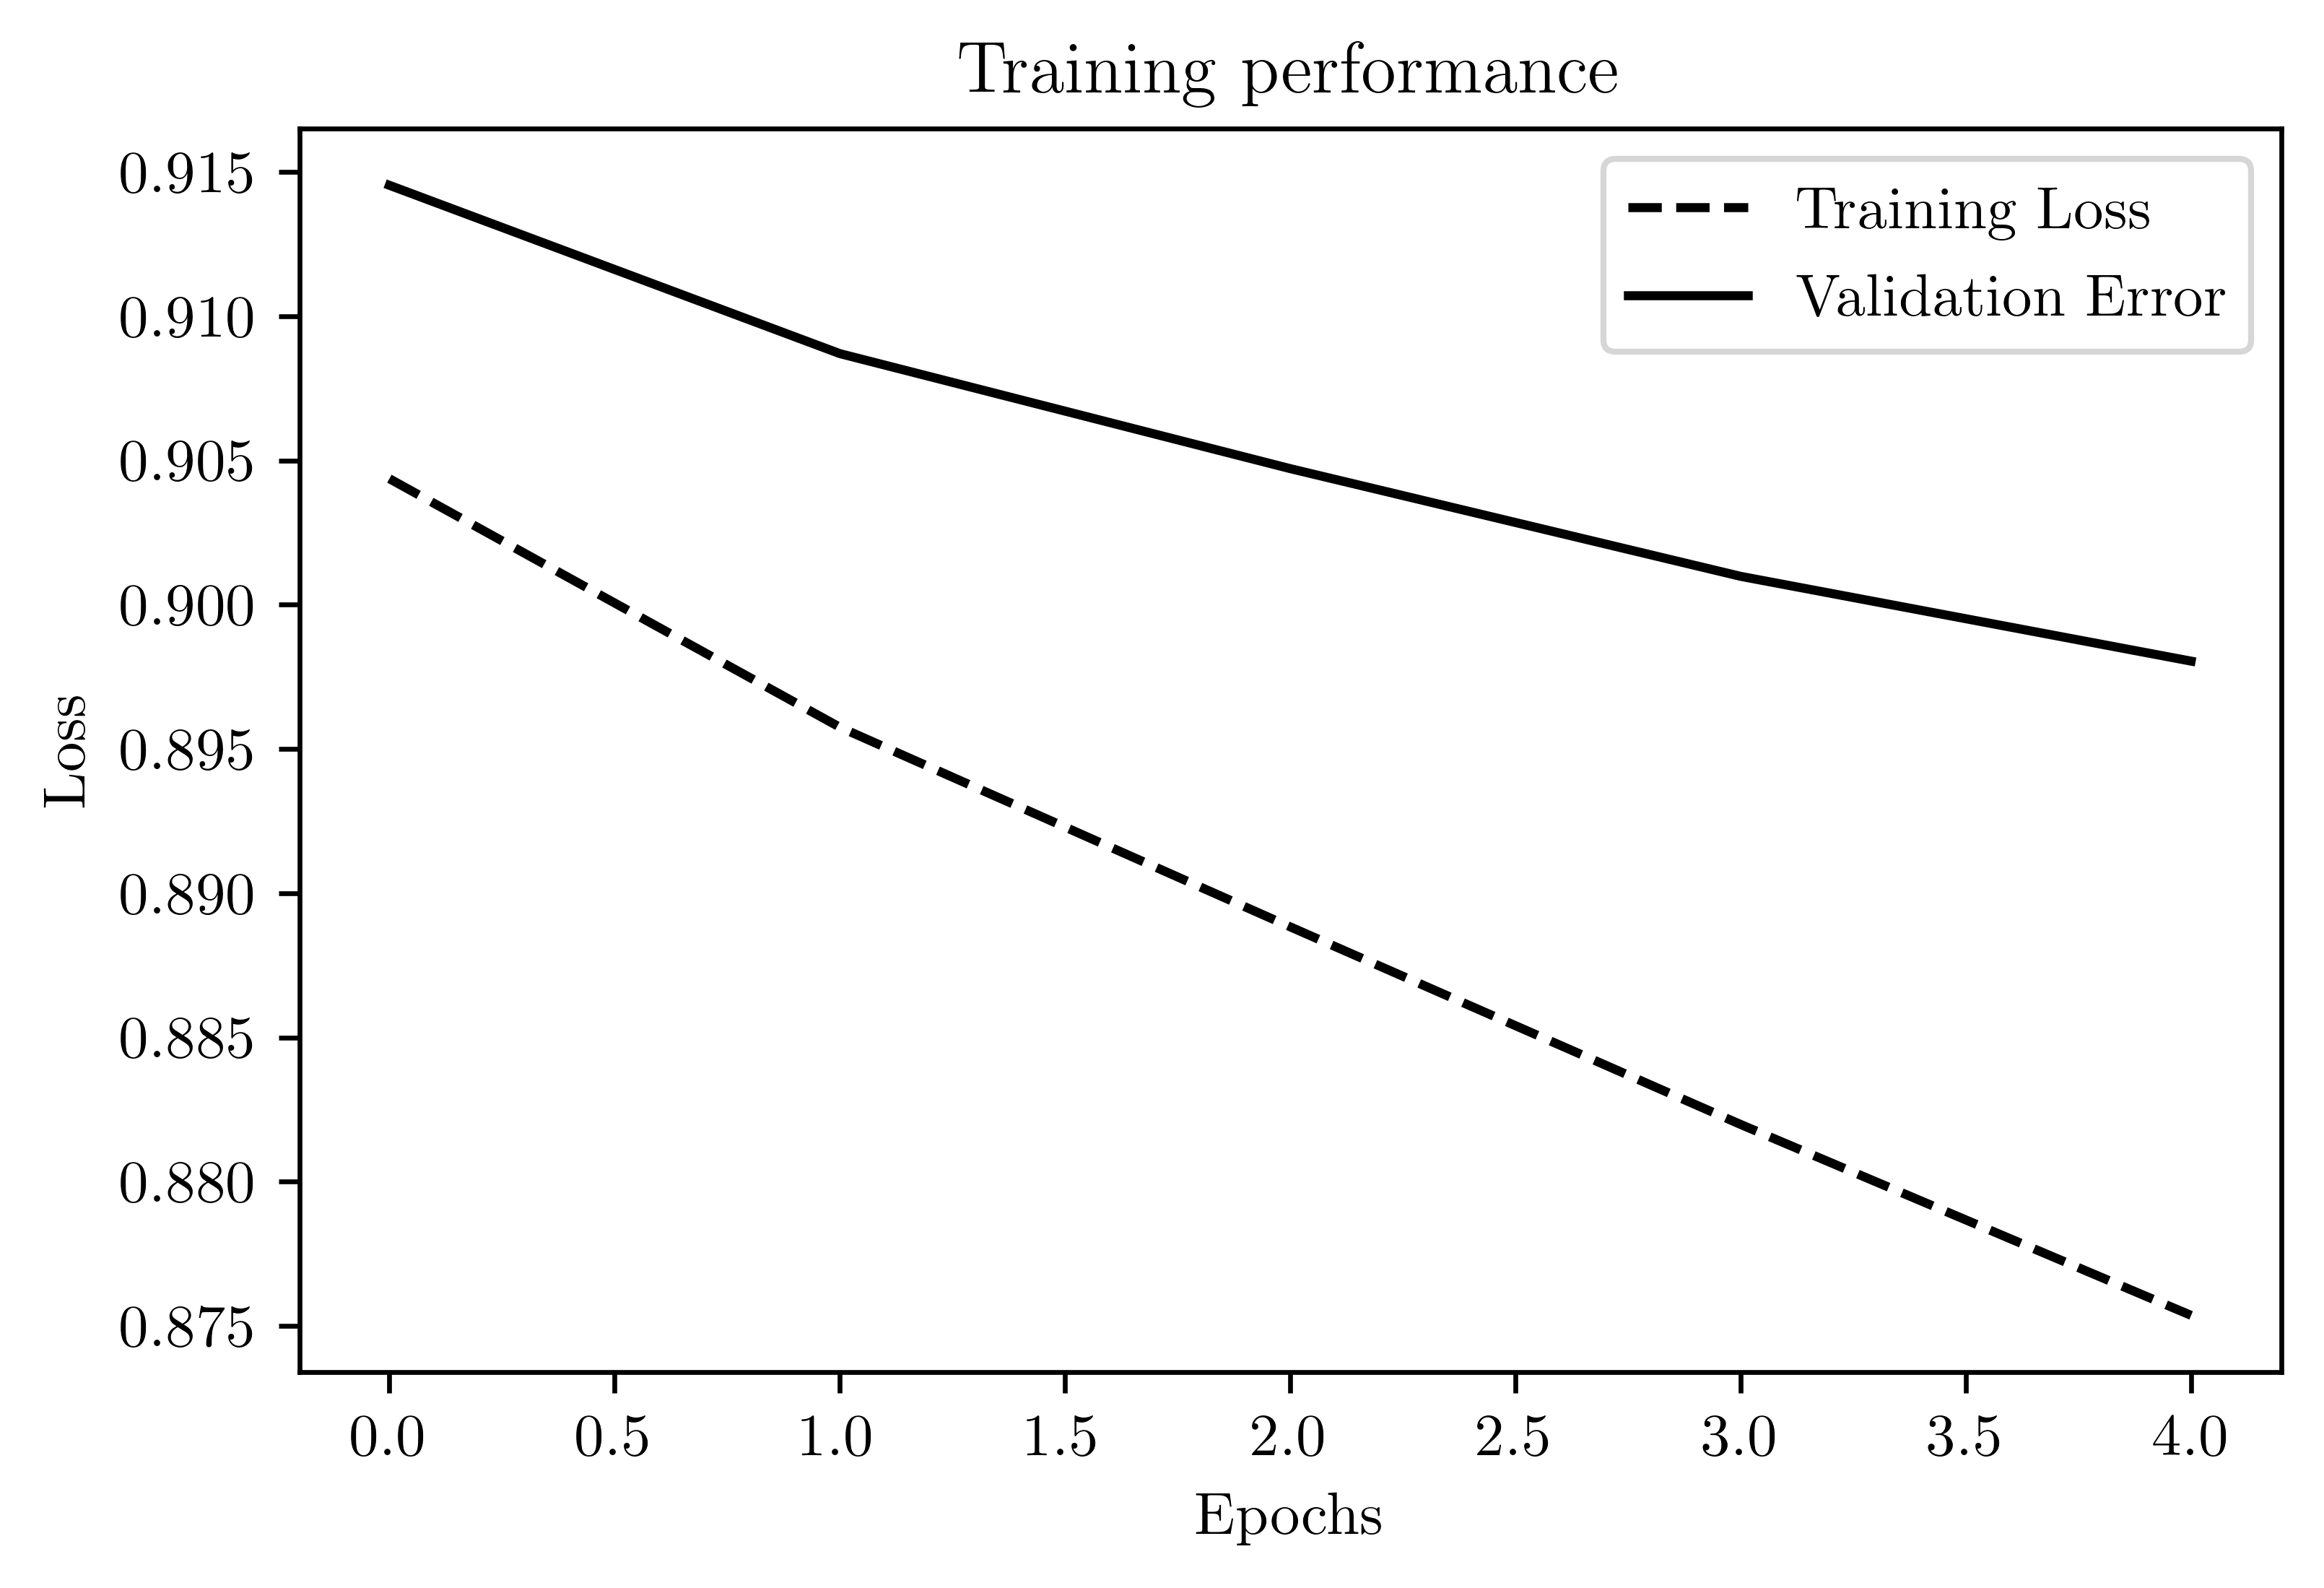

In [ ]:
matplotlib.pyplot.figure(figsize=(textwidth-0.2,3.8), dpi=600)

plt.title('Training performance')
plt.plot(qnn_history.epoch,qnn_history.history['loss'], linestyle="dashed", color="black", label='Training Loss')
plt.plot(qnn_history.epoch,qnn_history.history['val_loss'], color="black", label="Validation Error")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.savefig("QNN_Train_Validation_Loss.png", bbox_inches="tight")
plt.show()

In [ ]:
test_Y_hat = model.predict(x_test_tfcirc, batch_size=BATCH_SIZE)

In [ ]:
import time
start = time.perf_counter()
test_Y_hat = model.predict(x_test_tfcirc, batch_size=BATCH_SIZE)
end = time.perf_counter()

In [ ]:
print((end-start)/x_test_tfcirc.shape[0])
print(x_test_tfcirc.shape)

0.025126867550599855
(5000,)


In [ ]:
classes = ["BPSK", "QPSK"]

In [ ]:
print(test_Y_hat)

[[-0.56368816]
 [-0.06527525]
 [-0.07892716]
 ...
 [-0.7955815 ]
 [-0.9842431 ]
 [-0.9686549 ]]


In [ ]:
print(y_test_hinge)

[ 1.  1.  1. ... -1. -1. -1.]


In [ ]:
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,x_test_tfcirc.shape[0]):
    j = y_test_hinge[i]
    if j < 0:
      j = 1 # for qpsk
    else:
      j = 0 # for bpsk
    k = test_Y_hat[i]
    if k < 0:
      k = 1
    else:
      k = 0

    conf[k,j] = conf[k,j] + 1
num_acc = conf[0,0] + conf[1,1]
print(num_acc/len(y_test_hinge))
for i in range(0,len(classes)):
    confnorm[:,i] = conf[:,i] / np.sum(conf[:,i])

0.5572


(5000, 128, 2)


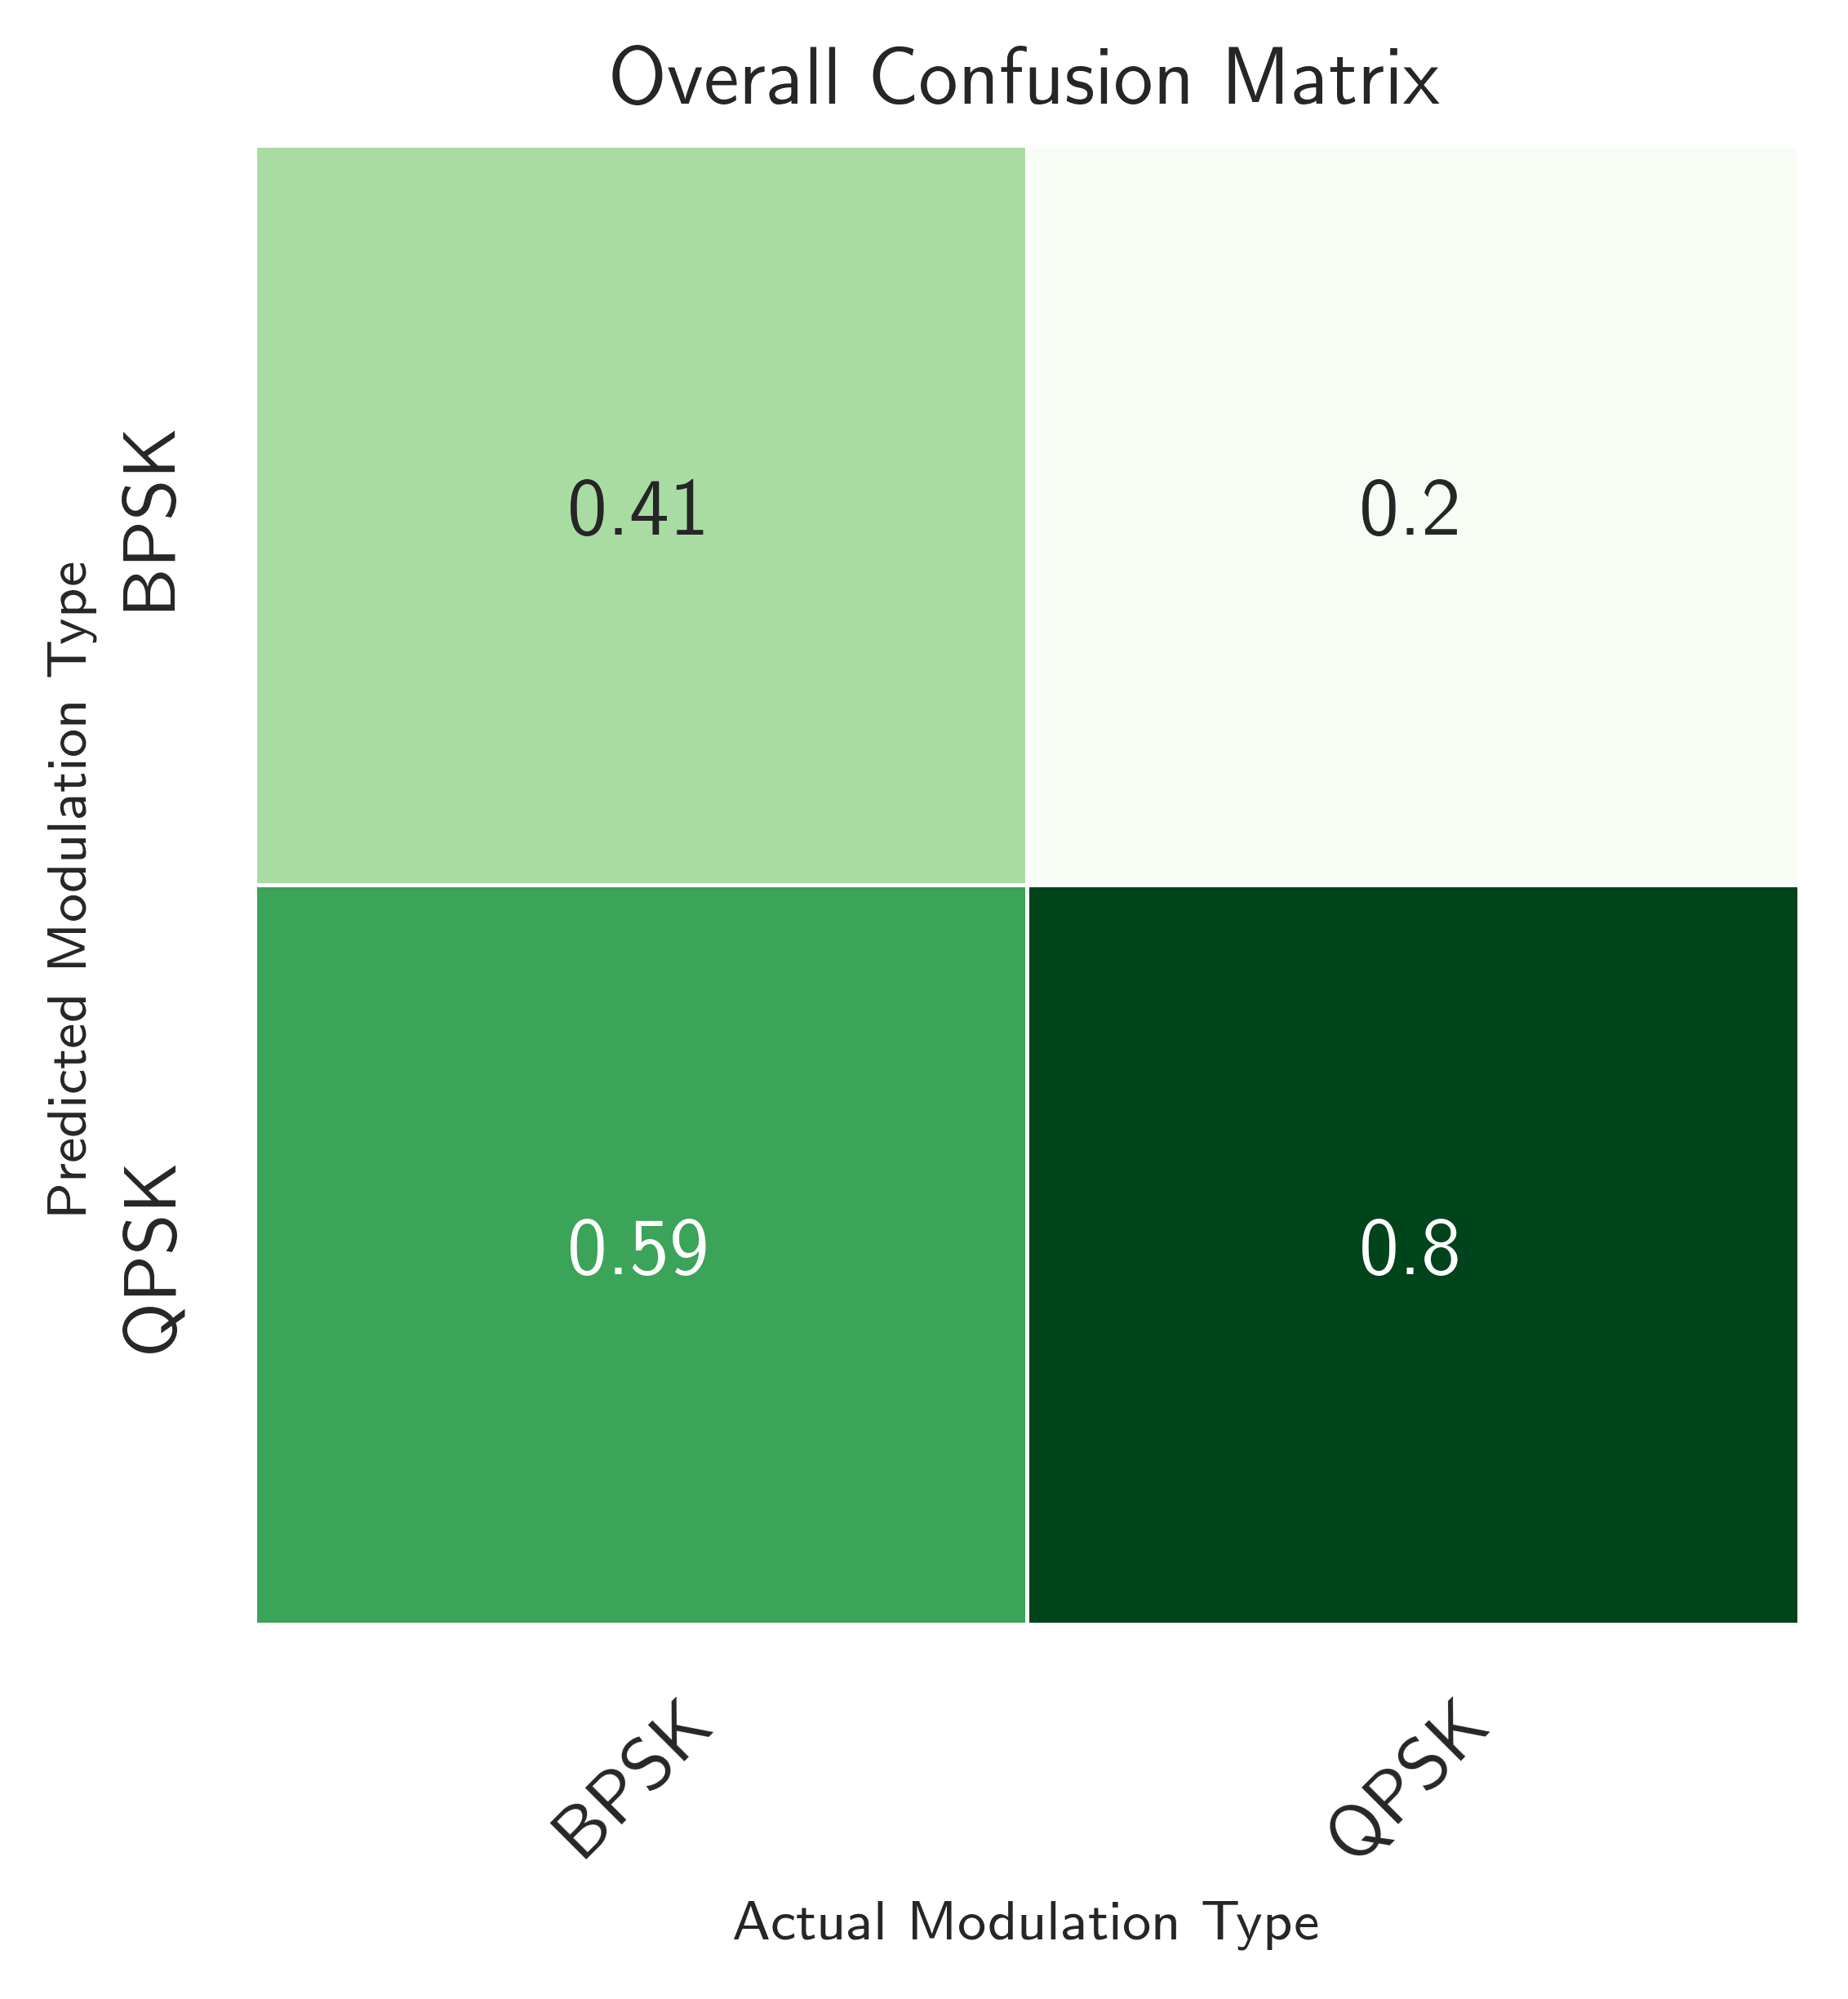

In [ ]:
print(X_test.shape)
#plt.figure(figsize=(7, 7), dpi=80)
matplotlib.pyplot.figure(figsize=(textwidth/1.5,4), dpi=600)
sn.set(rc={'figure.figsize':(textwidth,3.8), 'text.usetex' : True })
sn.set(font_scale=1) # for label size
ax = sn.heatmap(confnorm, annot=True, cmap="Greens", xticklabels=classes, yticklabels=classes, linewidths=0.5, cbar=False)
ax.set_xticklabels(classes,rotation=45)
ax.set_xlabel("Actual Modulation Type", fontsize="8")
ax.set_ylabel("Predicted Modulation Type", fontsize="8")
ax.set_title("Overall Confusion Matrix", fontsize="12")
#plot_confusion_matrix(confnorm, labels=classes)
fig = ax.get_figure()
fig.savefig("QNN_Overall_CM.png", bbox_inches="tight")

In [ ]:
def plot_small_confusion(title, data, classes, filename="" ):
  matplotlib.pyplot.figure(figsize=(textwidth/2.3,textwidth/2.3), dpi=600)
  sn.set(rc={'figure.figsize':(textwidth,3.8), 'text.usetex' : True })
  sn.set(font_scale=1) # for label size
  ax = sn.heatmap(confnorm, annot=True, cmap="Greens", xticklabels=classes, yticklabels=classes, linewidths=0.5, cbar=False)
  ax.set_xticklabels(classes,rotation=45)
  #ax.set_xlabel("Actual Modulation Type", fontsize="8")
  #ax.set_ylabel("Predicted Modulation Type", fontsize="8")
  ax.set_title(title, fontsize="12")
  #plot_confusion_matrix(confnorm, labels=classes)
  fig = ax.get_figure()
  fig.savefig(filename, bbox_inches="tight")

In [ ]:
test_x_accuracy = x_test_tfcirc.numpy()


Overall Accuracy:  0.5085599194360524
Overall Accuracy:  0.5178026449643948
Overall Accuracy:  0.5593719332679097
Overall Accuracy:  0.5898989898989899
Overall Accuracy:  0.6088669950738916


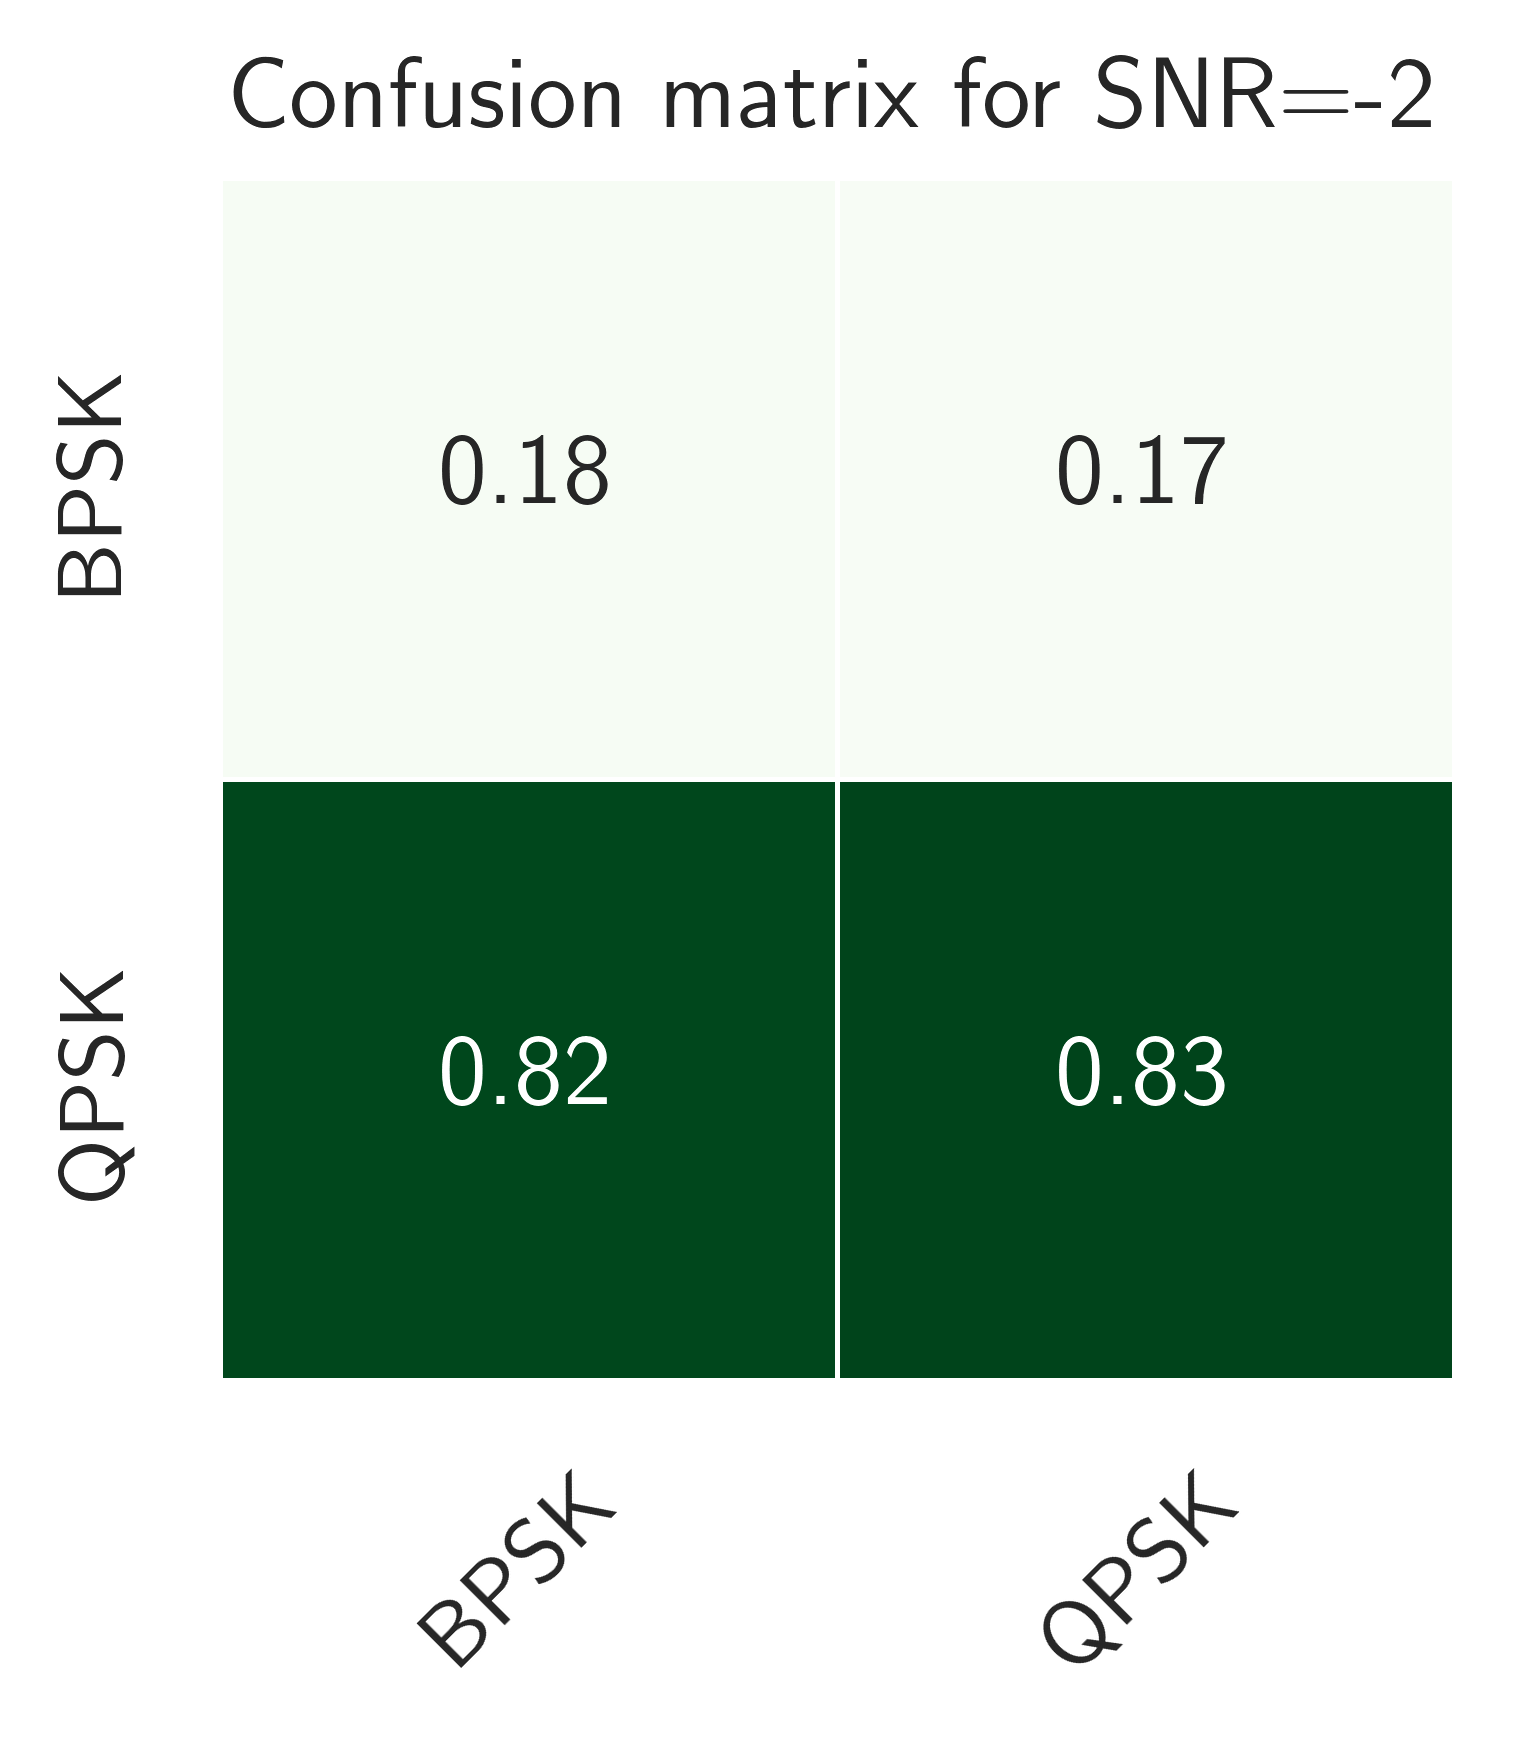

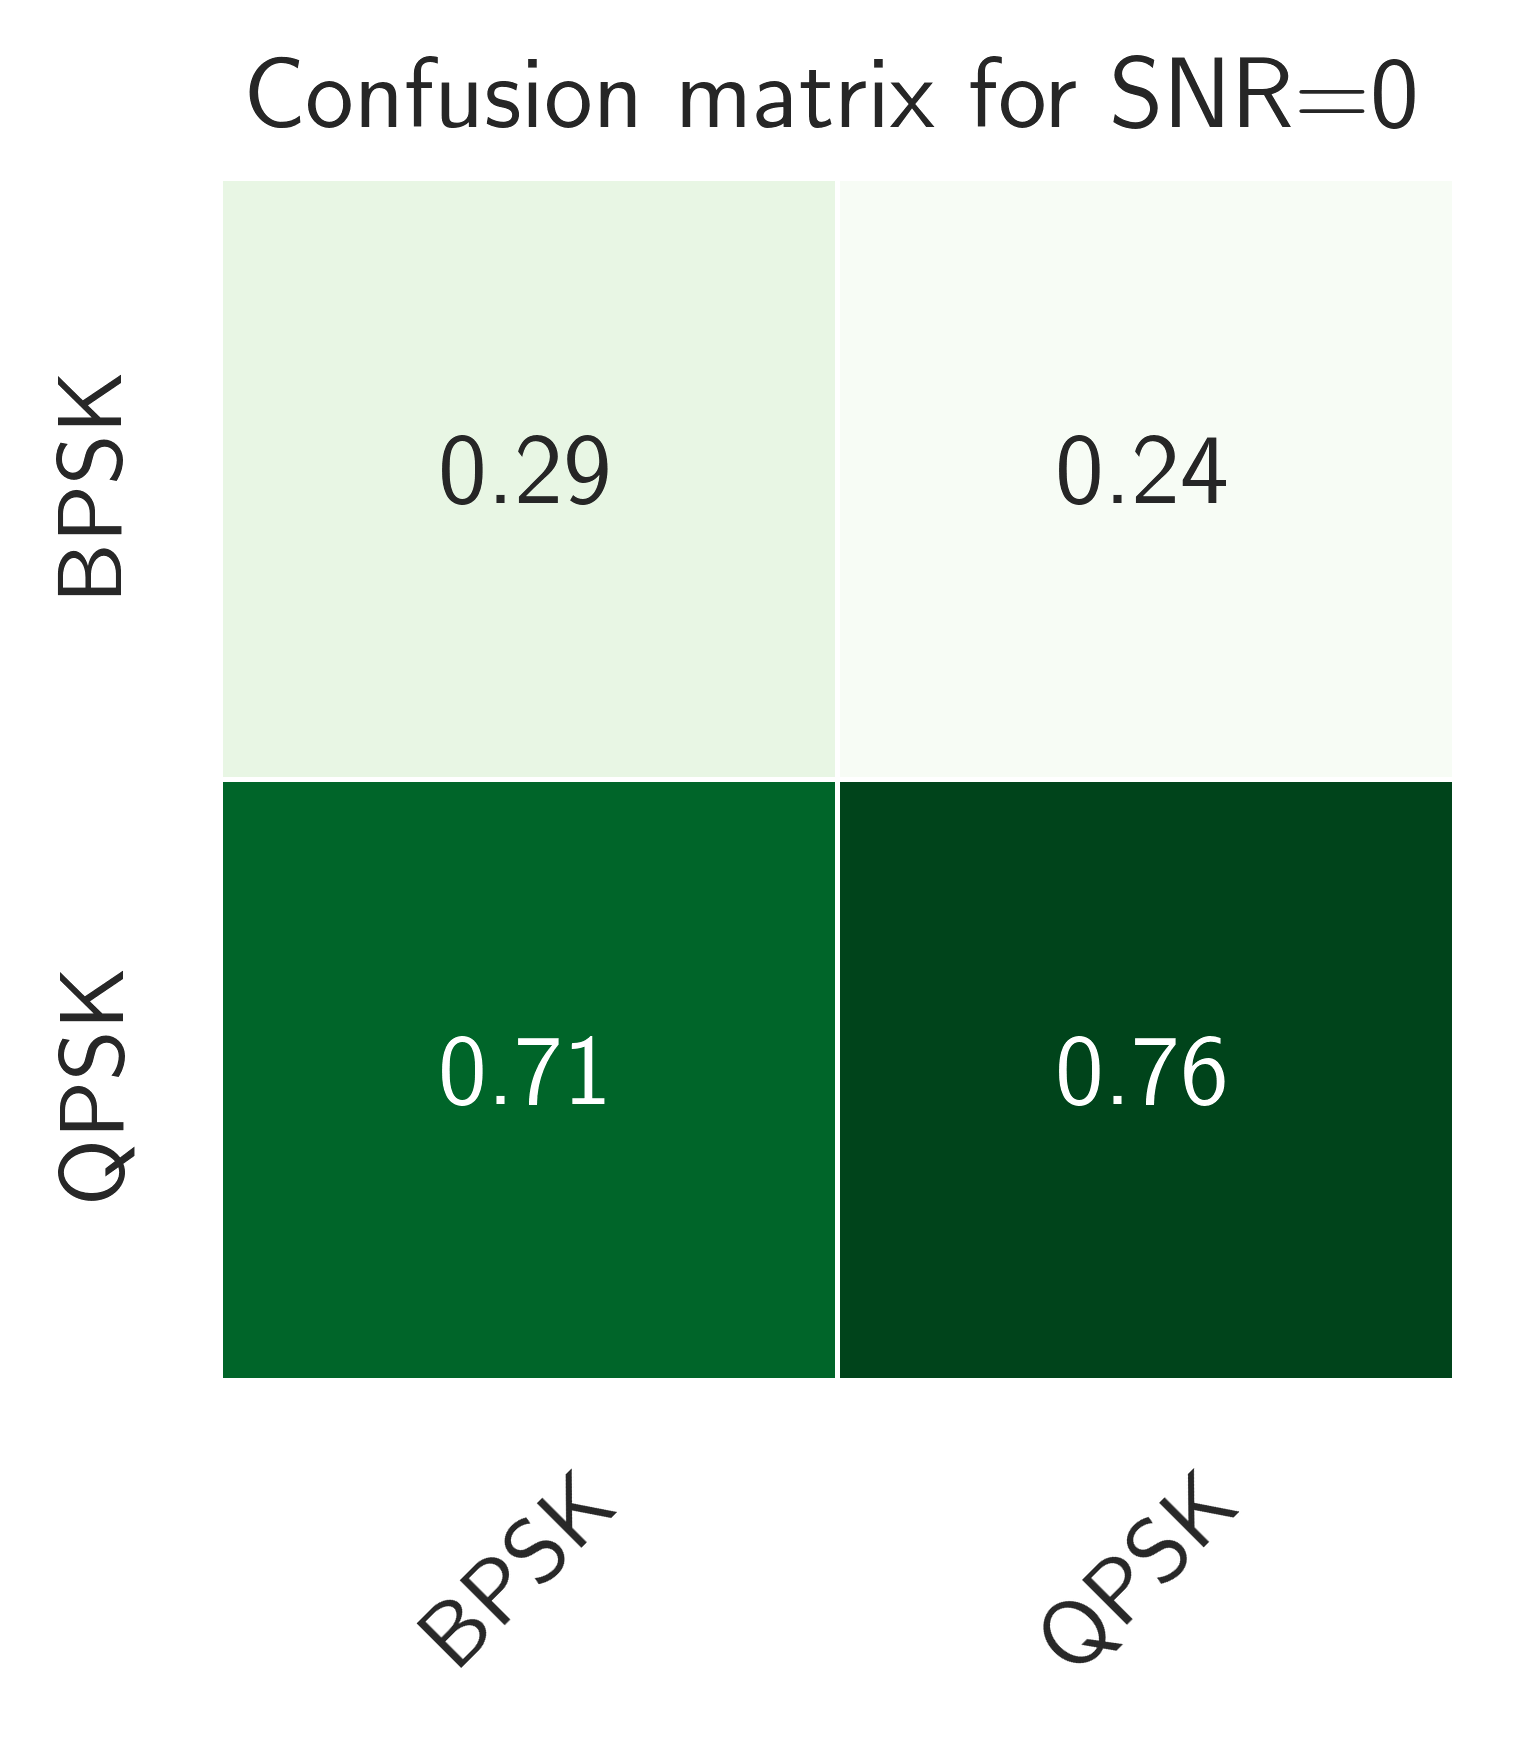

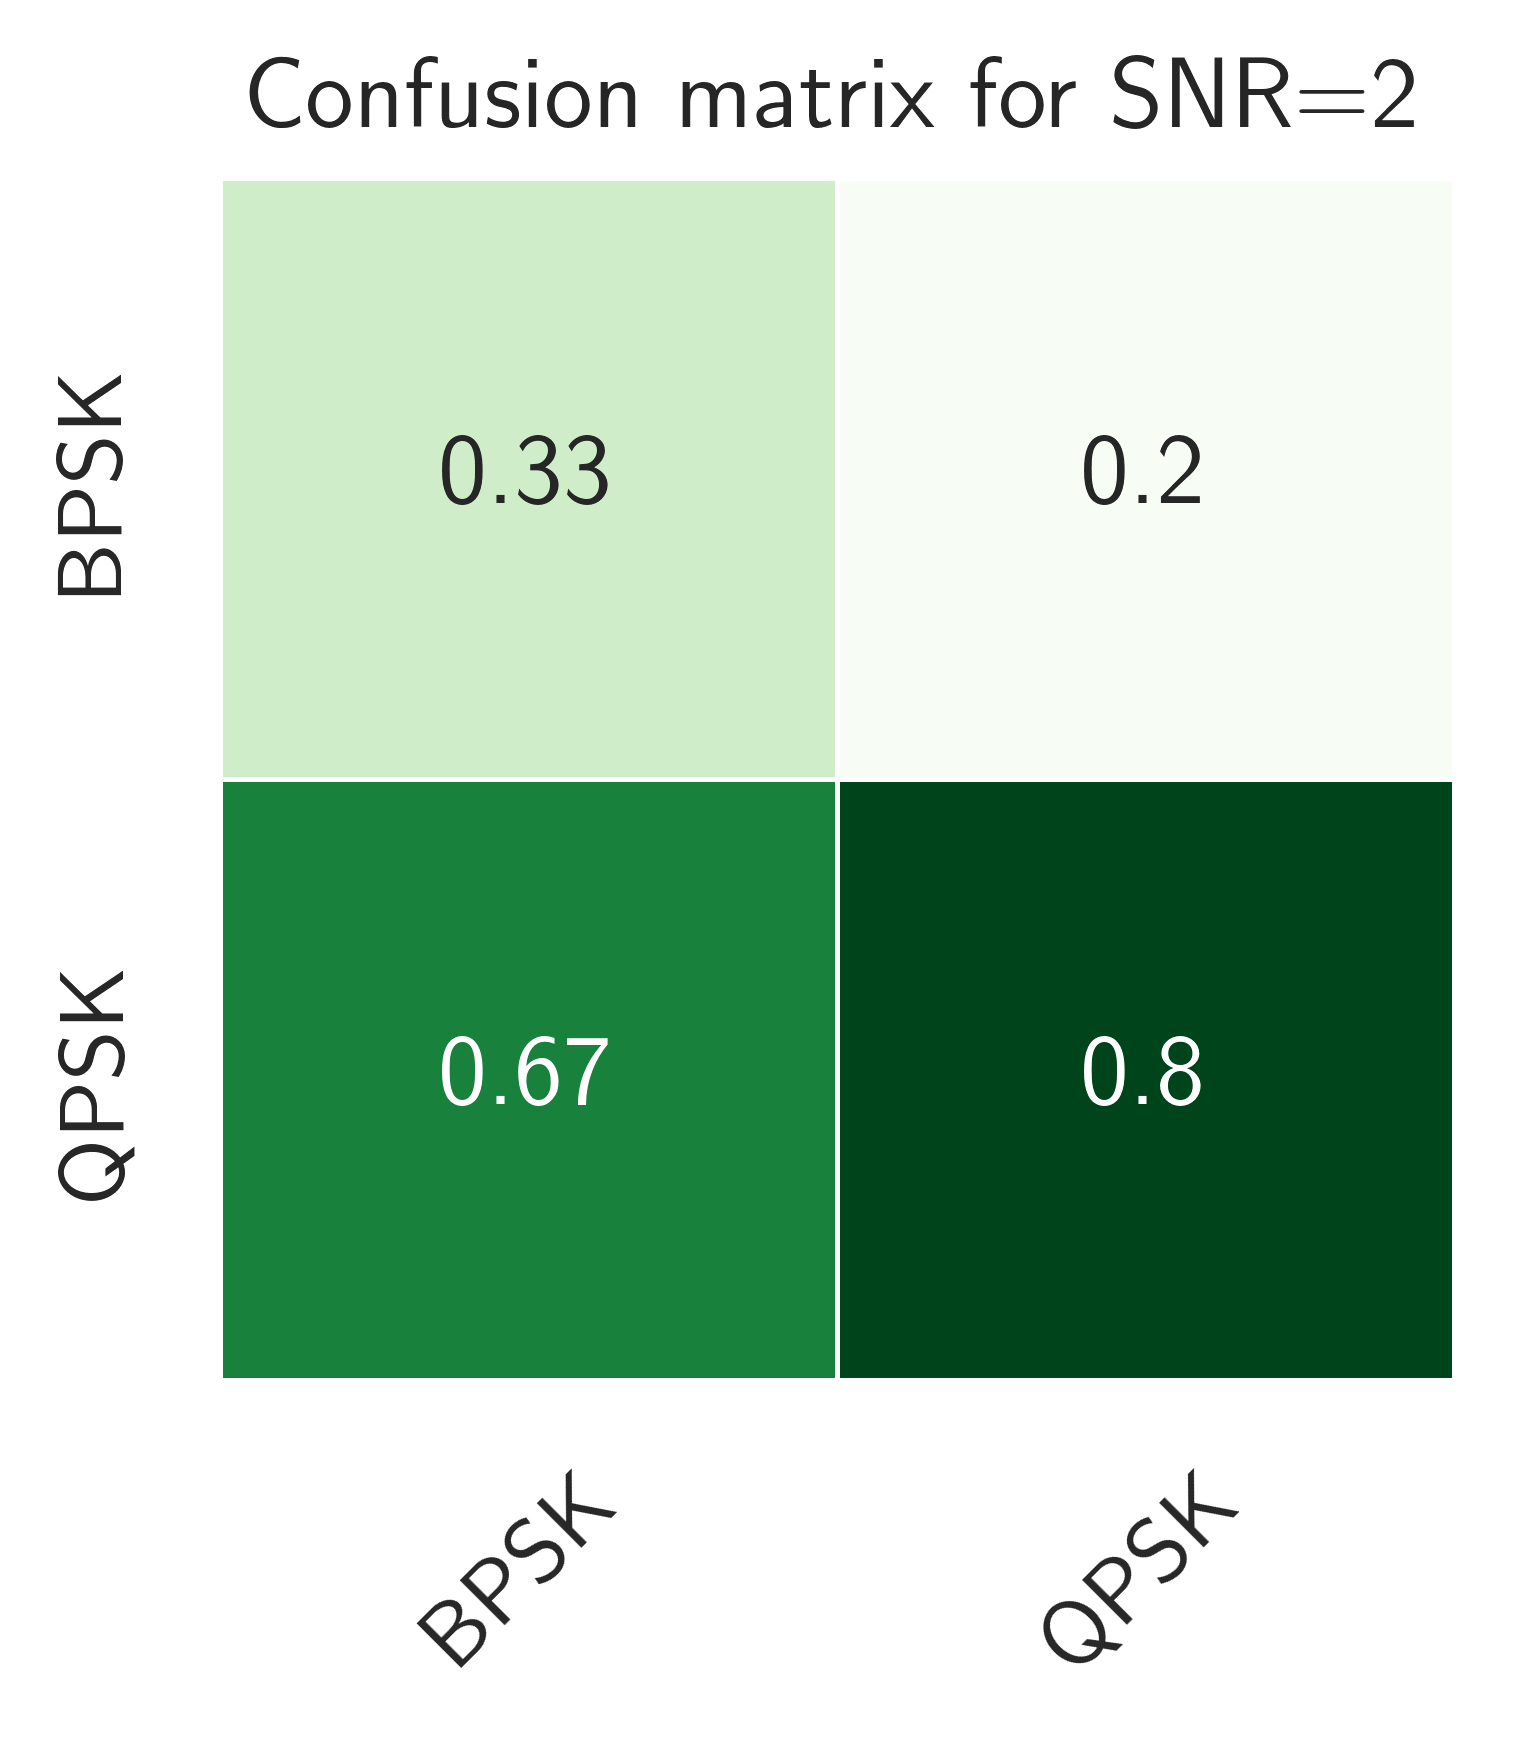

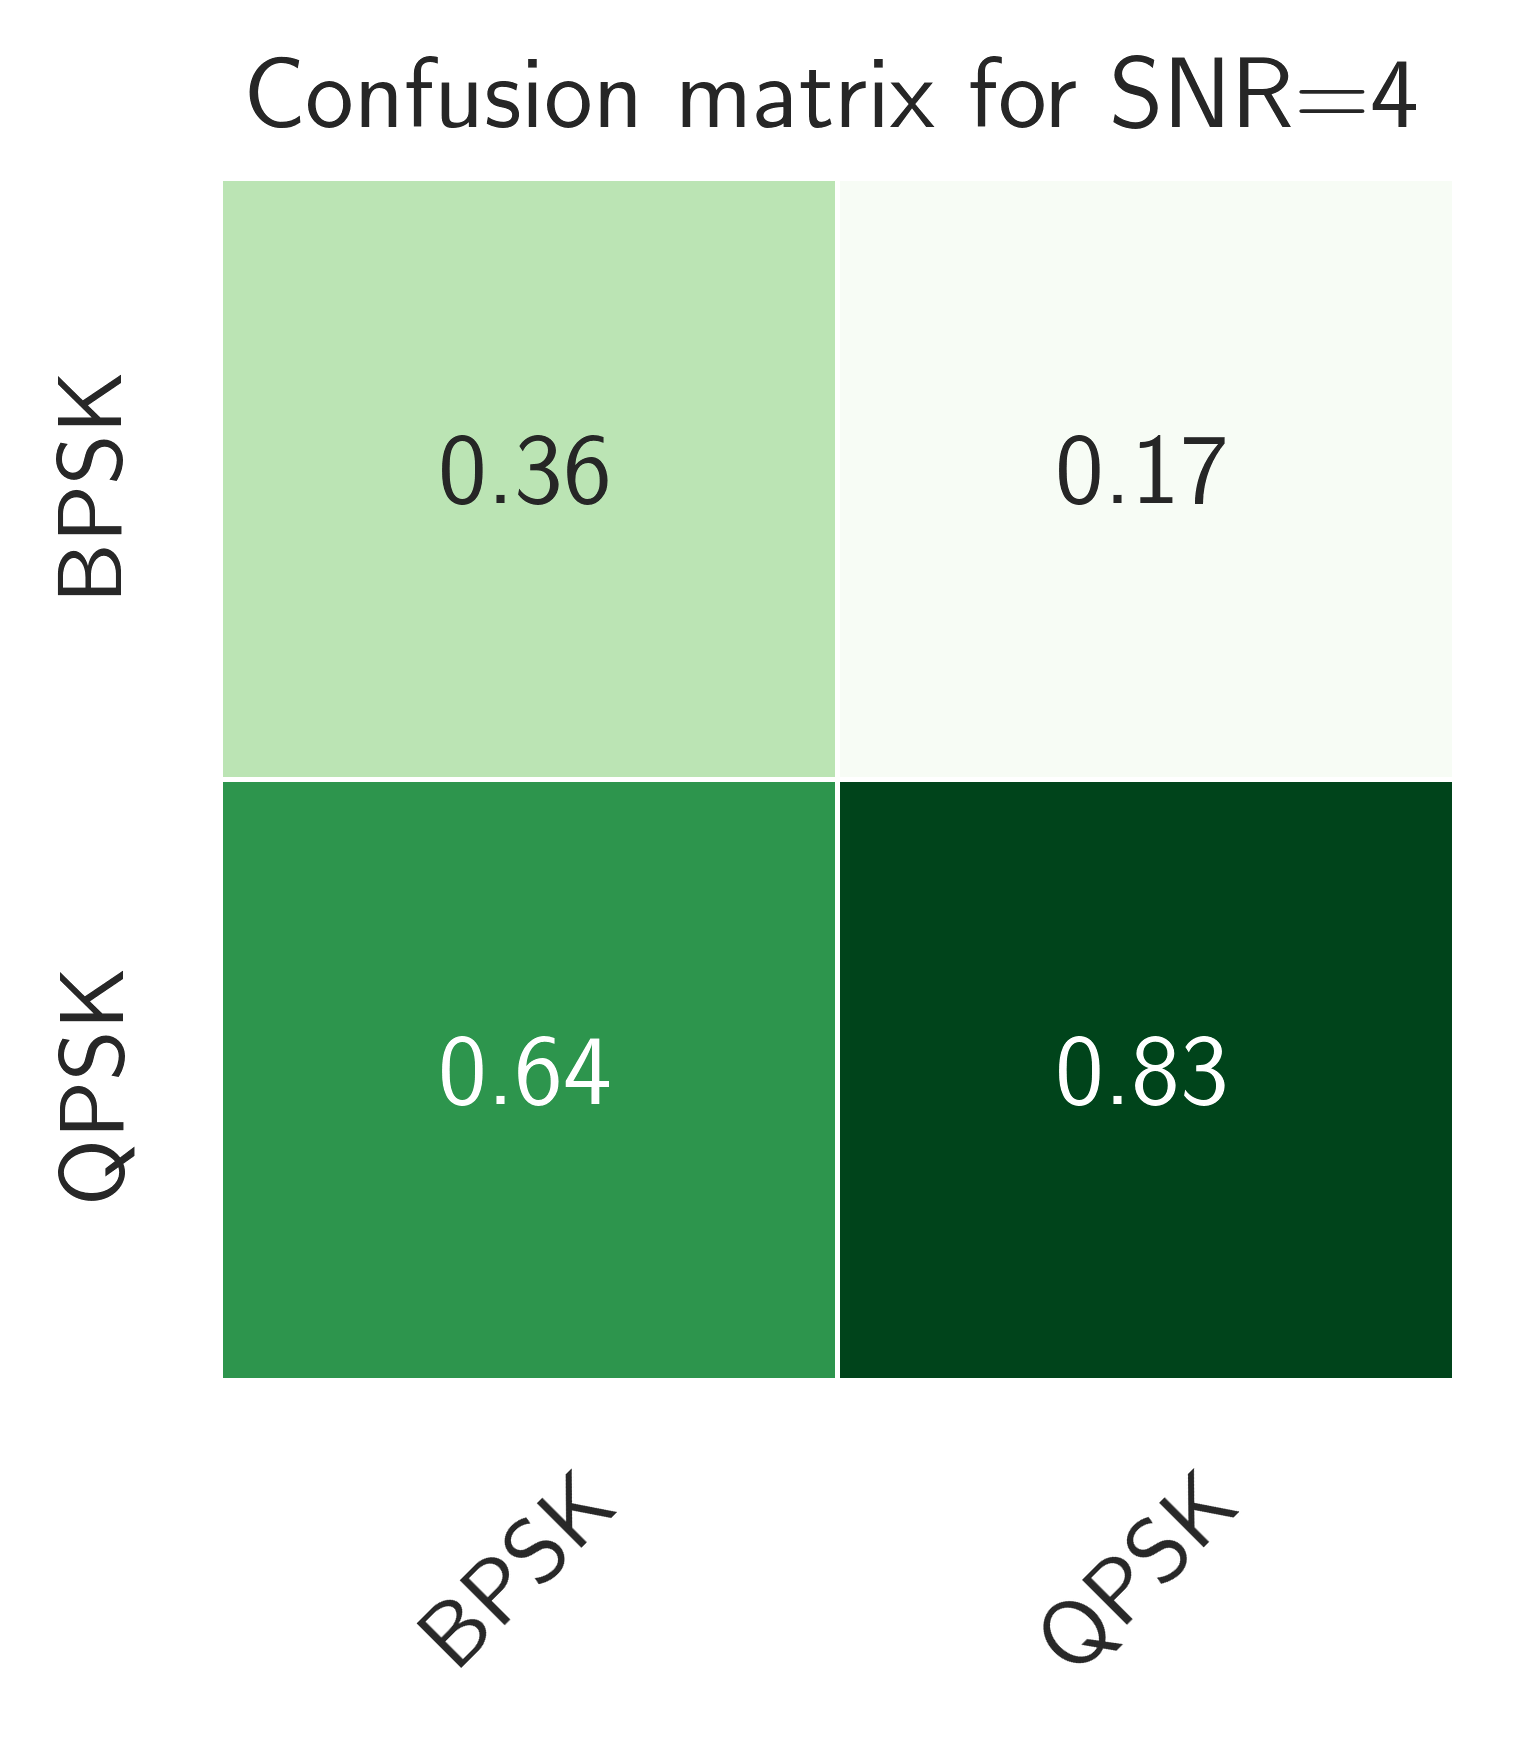

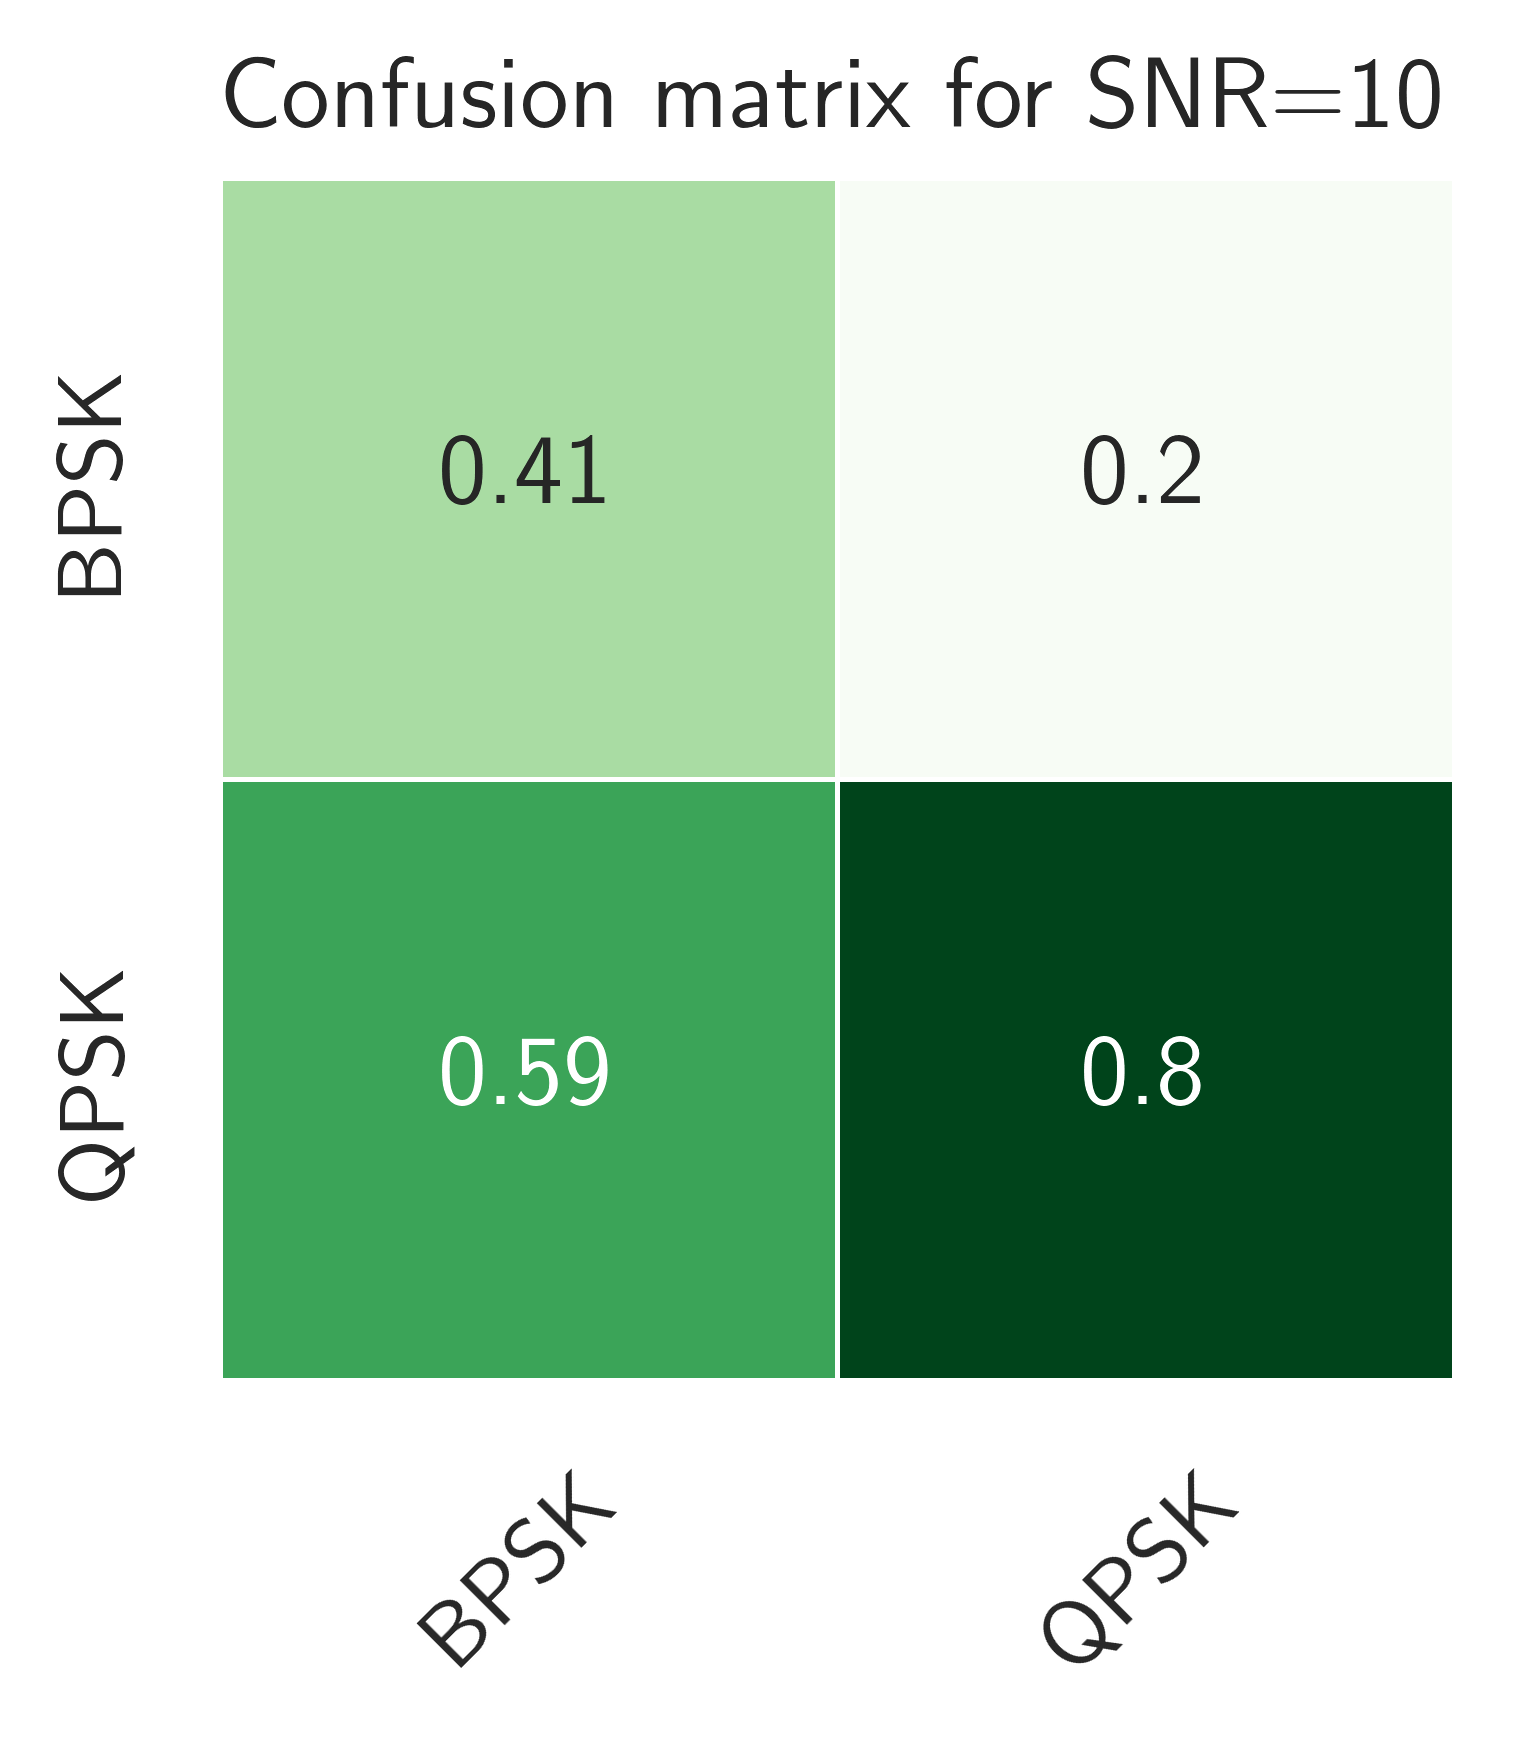

In [ ]:
acc = {}
test_SNRs = np.array( list(map(lambda x: lbl[x][1], test_idx) ) )
accuracies = list()
#test_x_accuracy = list(x_test)
for snr in snrs:

    # extract classes @ SNR
    #print(np.where(np.array(test_SNRs))==snr)
    #test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    #test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]
    test_X_i = test_x_accuracy[np.nonzero(test_SNRs == snr)]
    test_Y_i = y_test_hinge[np.nonzero(test_SNRs == snr)]


    #test_X_i = np.expand_dims( test_X_i, axis = 1 )
    if ( test_X_i.shape[0] == 0 ):
      continue
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i, batch_size = 1024 )
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = test_Y_i[i]
        if j < 0:
          j = 1 # for qpsk
        else:
          j = 0 # for bpsk
        k = test_Y_i_hat[i]
        if k < 0:
          k = 1
        else:
          k = 0

        conf[k,j] = conf[k,j] + 1
    for i in range(0,len(classes)):
        confnorm[:,i] = conf[:,i] / np.sum(conf[:,i])
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    plot_small_confusion("Confusion matrix for SNR="+str(snr), confnorm, classes,"QNN_CM_" + str(snr) + ".png")
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    accur = cor / ( cor + ncor )
    print("Overall Accuracy: ", accur)
    acc[snr] = 1.0*cor/(cor+ncor)
    accuracies.append(accur)
    #plt.plot(snr, cor/(cor+ncor))

In [ ]:
print(snrs)
print(accuracies)

[-2, 0, 2, 4, 10]
[0.5085599194360524, 0.5178026449643948, 0.5593719332679097, 0.5898989898989899, 0.6088669950738916]


In [ ]:
%matplotlib inline

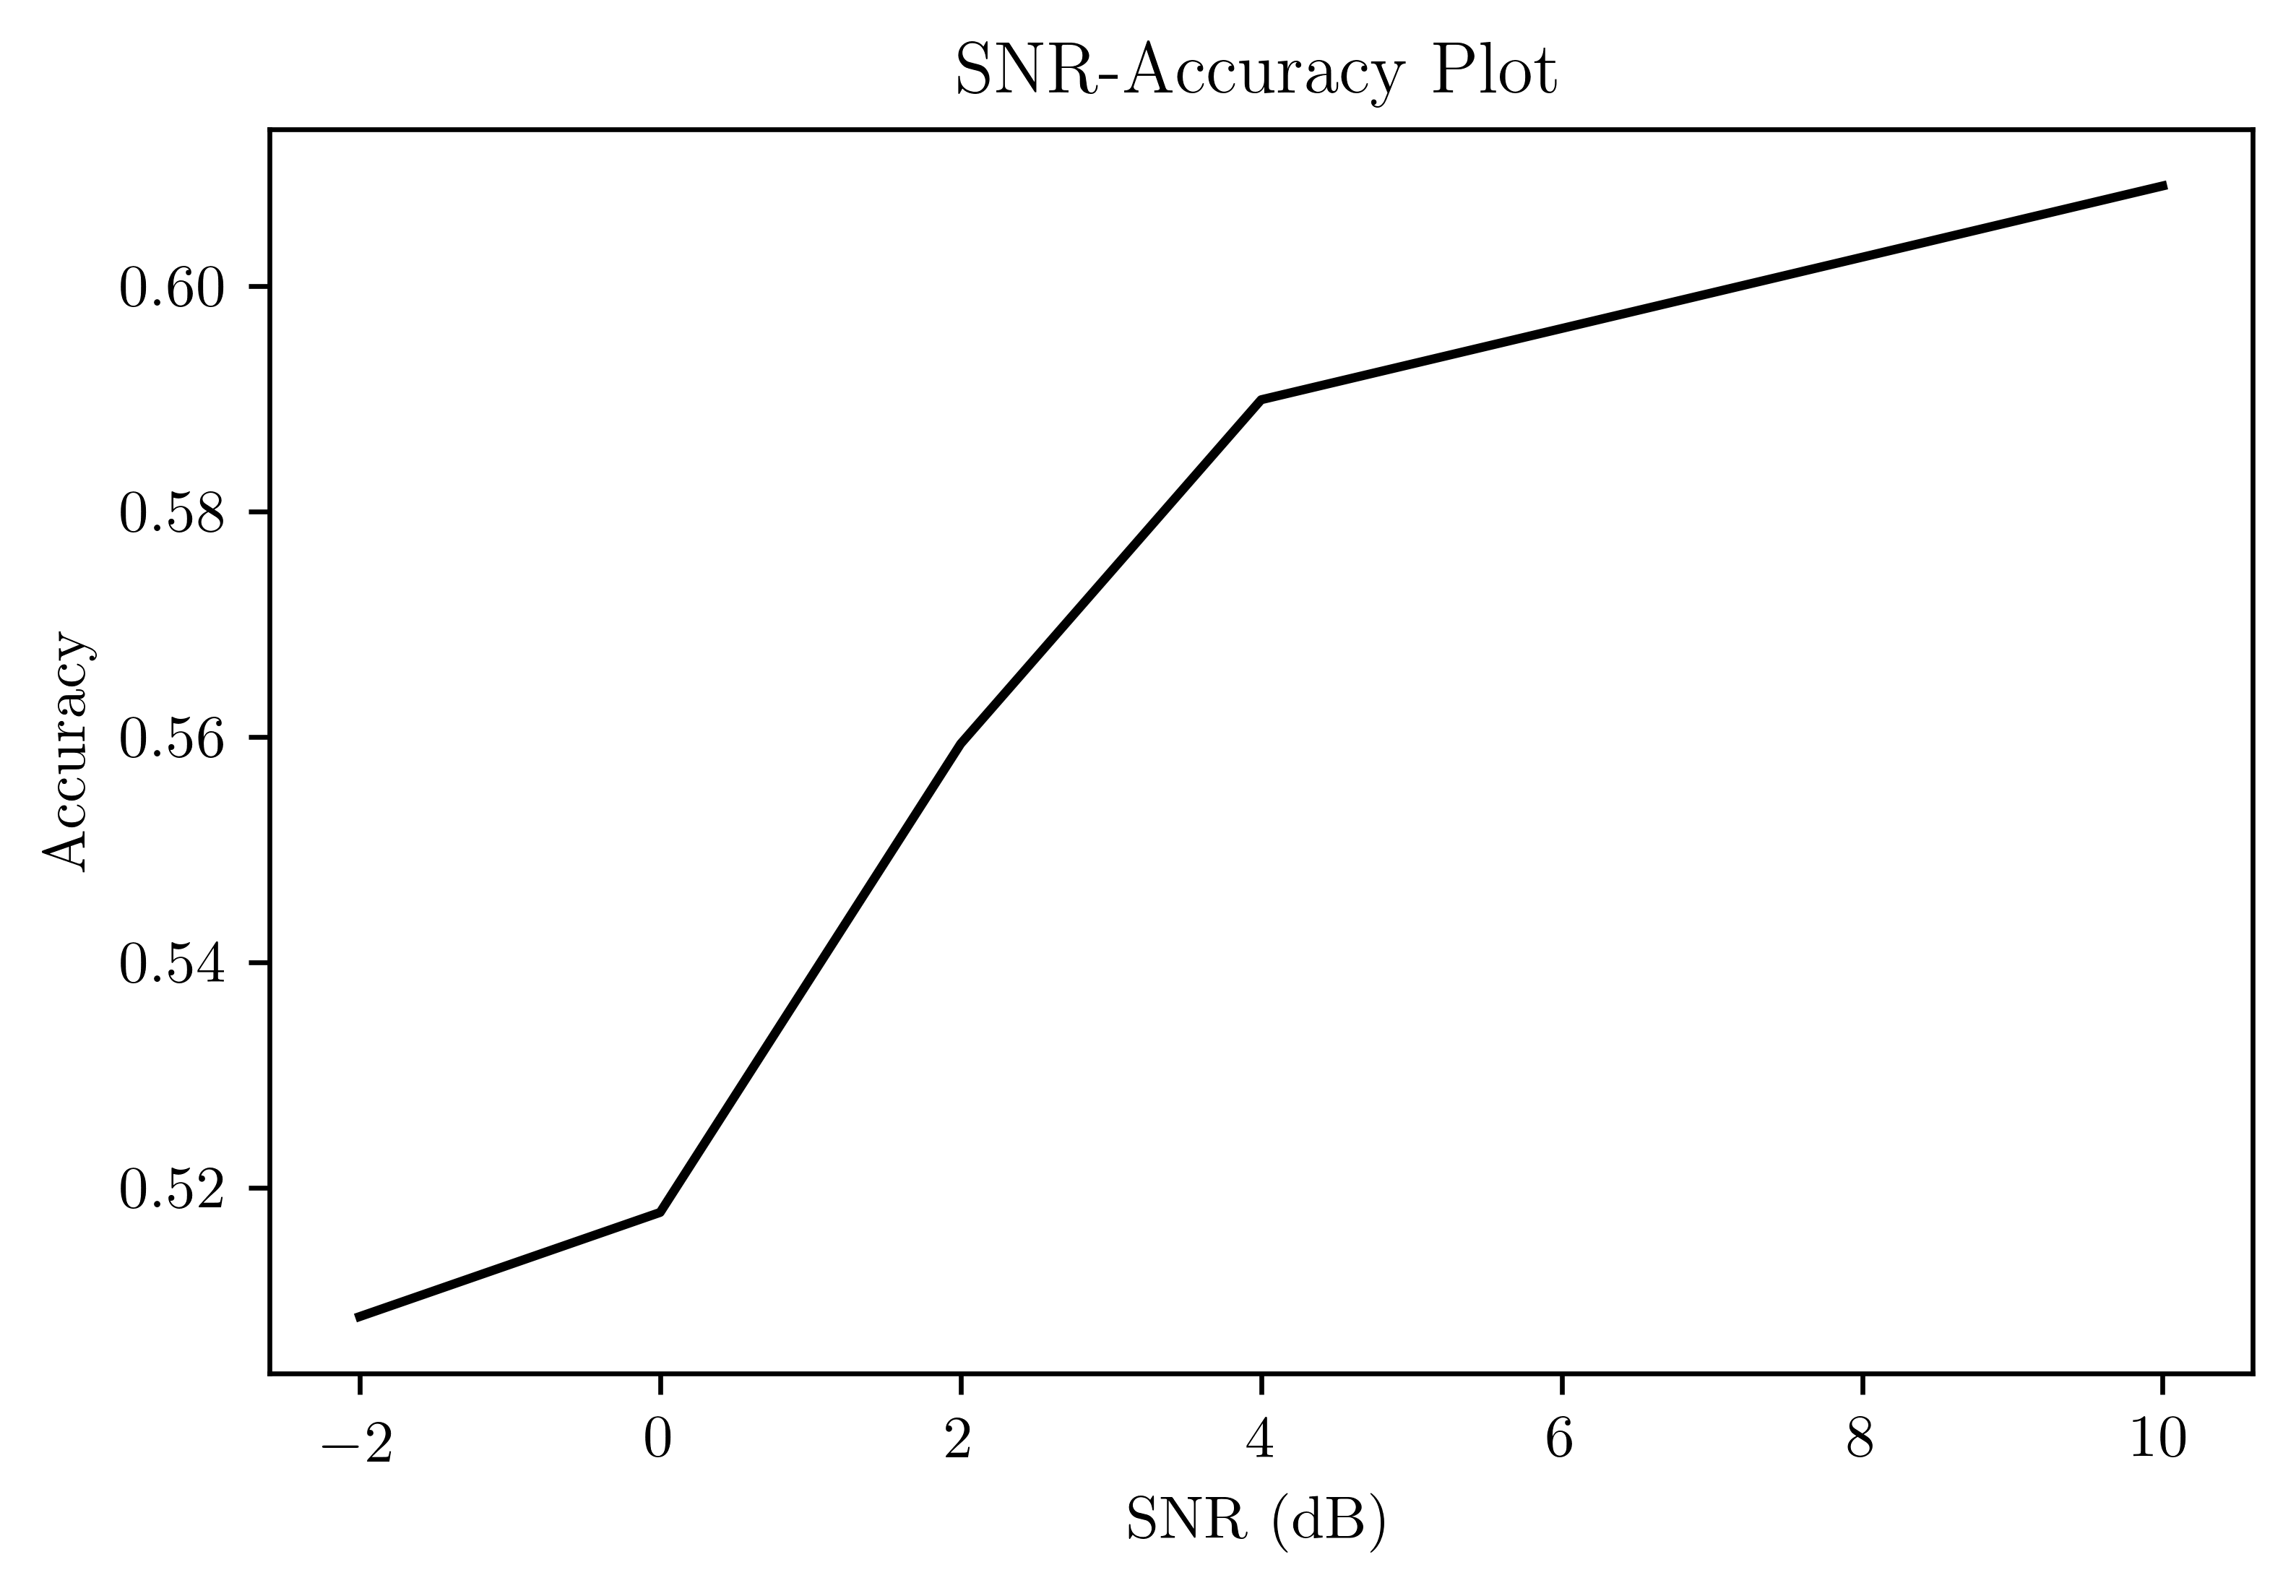

In [ ]:
#sn.set(font_scale=1.0) # for label size

#plt.style.use("default")

#fig = plt.figure()
matplotlib.pyplot.figure(figsize=(textwidth-0.2,3.8), dpi=600)
#fig.patch.set_facecolor("white")

plt.title('SNR-Accuracy Plot', fontsize="12")
ax = plt.plot(snrs,accuracies, color="black")
plt.grid(b=False)
plt.xlabel("SNR (dB)")
plt.ylabel("Accuracy")
plt.savefig("QNN_SNR_Acc.png", bbox_inches="tight")
plt.show()

In [ ]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#print(X_test.shape)
#test_Y_hat = model.predict(x_test_tfcirc, batch_size=batch_size)
#conf = np.zeros([len(classes),len(classes)])
#confnorm = np.zeros([len(classes),len(classes)])
#for i in range(0,X_test.shape[0]):
#    j = list(Y_test[i,:]).index(1)
#    k = int(np.argmax(test_Y_hat[i,:]))
#    conf[j,k] = conf[j,k] + 1
#for i in range(0,len(classes)):
#    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
#plt.figure(figsize=(7, 7), dpi=80)
#
#plot_confusion_matrix(confnorm, labels=classes)